In [1]:
using Distributions
using LinearAlgebra
using StatsFuns
using StatsBase

using LogDensityProblems
using LogDensityProblemsAD
using AbstractDifferentiation
using MCMCDiagnosticTools
using AdvancedHMC
using MicroCanonicalHMC
using Pathfinder
using Transducers

using Healpix
using HealpixMPI
using MPI

using Plots
using StatsPlots
using LaTeXStrings

using Random
using ProgressMeter
using BenchmarkTools
using NPZ
using CSV
using DataFrames
using Test

using Zygote: @adjoint
using Zygote
using ChainRules.ChainRulesCore

include("AD_parallSHT.jl")
include("gen_datatest.jl")
include("reparam.jl")
include("utils.jl")
include("inference_model.jl")
include("neglogproblem.jl")

nℓπ_grad (generic function with 1 method)

In [2]:
seed = 1123
Random.seed!(seed)

#   RESOLUTION PARAMETERS
nside = 64
lmax = 2*nside - 1

MPI.Init()

comm = MPI.COMM_WORLD
crank = MPI.Comm_rank(comm)
csize = MPI.Comm_size(comm)
root = 0
ncore = 12

12

In [3]:
#   REALIZATION MAP
realiz_Cl, realiz_HAlm, realiz_HMap = Realization("Capse_fiducial_Dl.csv", nside, lmax, seed)
realiz_θ = vcat(x_vecmat2vec(from_healpix_alm_to_alm([realiz_HAlm], lmax, 1, comm, root=root), lmax, 1, comm, root=root), Cl2Kl(realiz_Cl))

d = length(realiz_θ)

#   SURVEY MASK
mask_512 = readMapFromFITS("wmap_temperature_kq85_analysis_mask_r9_9yr_v5.fits",2,Float64)
mask_nside = udgrade(nest2ring(mask_512), nside)
for i in 1:length(mask_nside.pixels)
    if mask_nside.pixels[i]<=0.5
        mask_nside.pixels[i]=1
    else
        mask_nside.pixels[i]=0
    end
end

#   GENERATED DATA MEASUREMENTS
#   Noise
ϵ=1
N = ϵ*ones(nside2npix(nside))
N[mask_nside.==1] .= 5*10^4
#   Gaussian beam and pixel window function
Bl = gaussbeam(0.001, lmax, pol=false)
Pl = pixwin(nside, pol=false)[1:lmax+1]
BP_l = Bl.*Pl

#   Data Map
gen_Cl, gen_HAlm, gen_HMap = Measurement(realiz_Cl, Bl, Pl, mask_nside, N, nside, lmax, seed)
gen_θ = vcat(x_vecmat2vec(from_healpix_alm_to_alm([gen_HAlm], lmax, 1, comm, root=root), lmax, 1, comm, root=root), Cl2Kl(gen_Cl))
invN_HMap = HealpixMap{Float64,RingOrder}(1 ./ N)

#   STARTING POINT
start_Cl, start_HAlm, start_HMap = StartingPoint(gen_Cl, nside)
start_θ = vcat(x_vecmat2vec(from_healpix_alm_to_alm([start_HAlm], lmax, 1, comm, root=root), lmax, 1, comm, root=root), Cl2Kl(start_Cl))

#   PROMOTE HEALPIX.MAP TO HEALIPIXMPI.DMAP
gen_DMap = DMap{RR}(comm)
invN_DMap = DMap{RR}(comm)
HealpixMPI.Scatter!(gen_HMap, gen_DMap, comm, clear=true)
HealpixMPI.Scatter!(invN_HMap, invN_DMap, comm, clear=true)

helper_DMap = deepcopy(gen_DMap)

DMap{RR, Float64}([0.0; 0.0; … ; -34.64859660904887; 31.260619547543623;;], GeomInfoMPI(MPI.Comm(1140850688), 64, 256, [1.5707963267948966, 1.5603794717389192, 1.581213181850874, 1.5499614861262483, 1.5916311674635448, 1.5395412382954015, 1.6020514152943917, 1.5291175943723188, 1.6124750592174744, 1.5186894171565548  …  0.06379961522501076, 3.0777930383647822, 0.05103657515266638, 3.090556078437127, 0.038275613631490575, 3.1033170399583025, 0.02551621035741883, 3.1160764432323744, 0.012757845597670932, 3.128834807992122], [128, 127, 129, 126, 130, 125, 131, 124, 132, 123  …  5, 251, 4, 252, 3, 253, 2, 254, 1, 255], [1, 257, 513, 769, 1025, 1281, 1537, 1793, 2049, 2305  …  49033, 49053, 49073, 49089, 49105, 49117, 49129, 49137, 49145, 49149], [256, 256, 256, 256, 256, 256, 256, 256, 256, 256  …  20, 20, 16, 16, 12, 12, 8, 8, 4, 4], [1.5707963267948966, 1.5603794717389192, 1.581213181850874, 1.5499614861262483, 1.5916311674635448, 1.5395412382954015, 1.6020514152943917, 1.529117594372318

In [4]:
nlp = nℓπ(start_θ, data=gen_DMap, helper_DMap=helper_DMap, lmax=lmax, nside=nside, BP_l=Bl.*Pl, invN=invN_DMap, ncore=ncore, comm=comm, root=root)
nlp_grad = nℓπ_grad(start_θ, data=gen_DMap,  helper_DMap=helper_DMap, lmax=lmax, nside=nside, BP_l=Bl.*Pl, invN=invN_DMap, ncore=ncore, comm=comm, root=root)

([-49429.41714375906, -19317.13512189587, 58440.55438002808, 37884.2773012911, 57929.29353498969, 128326.72043300763, 8502.163274624367, -41126.21676744812, -56265.46566400849, -50013.29333692165  …  -3.3403461282010802, -3.2726705662126148, -3.2612826088387155, -3.266910899485247, -3.3150427423477997, -3.3372931096879435, -3.333563987051014, -3.2426388910880366, -3.298151544413371, -3.2358893213668023],)

In [7]:
j=16500
e=zeros(d)
e[j]+=0.0001
(nℓπ(start_θ+e)-nℓπ(start_θ-e))/0.0002

-3.2570213079452515

In [8]:
nlp_grad[1][j]

-3.257055641553557

In [72]:
## BENCHMARKING POSTERIOR and POSTERIOR+GRADIENTS TIMINGS
MPI.Barrier(comm)
nlp_bm = @benchmark nℓπ(start_θ)

BenchmarkTools.Trial: 2972 samples with 1 evaluation.
 Range (min … max):  1.227 ms … 179.890 ms  ┊ GC (min … max):  0.00% … 99.02%
 Time  (median):     1.420 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.678 ms ±   3.339 ms  ┊ GC (mean ± σ):  14.79% ± 16.77%

  ▁▅▇█▆▄▃▂                                                    ▁
  ████████▇▅▃▁▄▁▁▁▁▁▁▁▁▁▃▄▆▆▇▆▅▅▃▅▆▆▆▇▆▆▇█▆▆▆▆▇▇▇▇▆▆▇▆▆▆▄▃▅▄▆ █
  1.23 ms      Histogram: log(frequency) by time      4.48 ms <

 Memory estimate: 5.26 MiB, allocs estimate: 25647.

In [73]:
MPI.Barrier(comm)
nlp_grad_bm = @benchmark nℓπ_grad(start_θ)

BenchmarkTools.Trial: 1292 samples with 1 evaluation.
 Range (min … max):  2.866 ms … 44.132 ms  ┊ GC (min … max):  0.00% …  0.00%
 Time  (median):     3.232 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.866 ms ±  2.018 ms  ┊ GC (mean ± σ):  13.72% ± 17.26%

  ▂▅▆█▇▆▄▂▁▁                  ▁ ▁▁  ▂   ▁                     
  ██████████▇█▆▇█▅▆▅▇▆▇█▅▇▇▇██████▇███▇▇███▅▇▇▅▅▆▆▁▆▄▄▁▁▁▁▁▅ █
  2.87 ms      Histogram: log(frequency) by time     7.72 ms <

 Memory estimate: 12.37 MiB, allocs estimate: 52798.

In [9]:
struct PF_LogTargetDensity
    dim::Int
end
LogDensityProblems.capabilities(::Type{PF_LogTargetDensity}) = LogDensityProblems.LogDensityOrder{1}()
LogDensityProblems.dimension(p::PF_LogTargetDensity) = p.dim
LogDensityProblems.logdensity(p::PF_LogTargetDensity, θ) = -nℓπ(θ)

PF_problem = ADgradient(:Zygote, PF_LogTargetDensity(d))

PF_seed = rand(1:10_000)
Random.seed!(PF_seed)
#PFinit_θ = Vector{Vector{Float64}}(undef, 5)
#for i in 1:5
#    PFinit_θ[i] = rand(MvNormal(start_θ,I))
#end
PFinit_θ = rand(MvNormal(start_θ,0.1*I))
MPI.Barrier(comm)
t0 = time()
result = pathfinder(PF_problem, ndraws=10, init=PFinit_θ)
PF_t = time()-t0

49.76397895812988

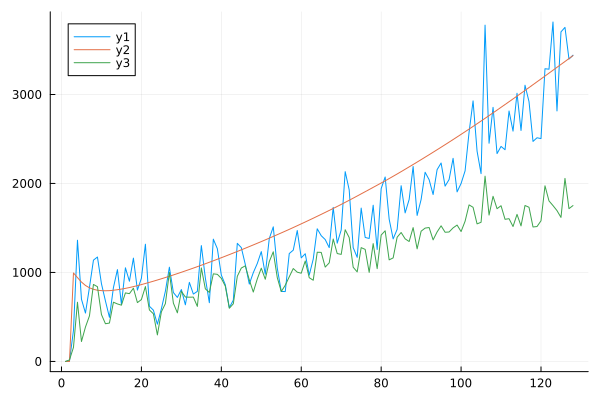

In [10]:
plot(cl2dl(Kl2Cl(result.draws[end-lmax:end,end], comm, root=0), 0))
plot!(cl2dl(realiz_Cl,0))
plot!(cl2dl(gen_Cl, 0))

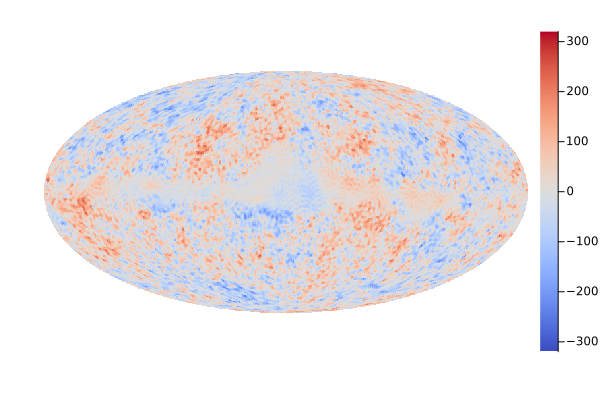

In [9]:
plot(Healpix.alm2map(from_alm_to_healpix_alm(x_vec2vecmat(result.draws[1:end-lmax-1,end], lmax, 1), lmax, 1)[1], nside), color=:coolwarm,
clim=(-320,320))

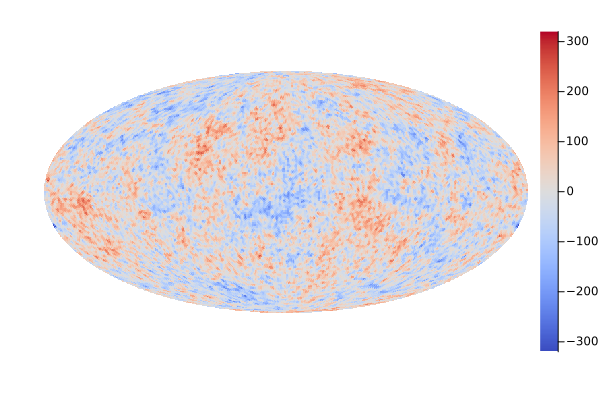

In [10]:
plot(realiz_HMap, color=:coolwarm, clim=(-320,320))

In [11]:
PF_start_θ = result.draws[:,end]
function MCHMCℓπ(θ)
    return -nℓπ(θ) #ricorda -1
end

function MCHMCℓπ_grad(x)
    f, df = nℓπ(x), nℓπ_grad(x) #ricorda -1
    return -f, -df[1]
end

MCHMCℓπ_grad (generic function with 1 method)

In [18]:
target = CustomTarget(MCHMCℓπ, MCHMCℓπ_grad, PF_start_θ)

n_adapts, n_steps = 2_000, 10_000
spl = MicroCanonicalHMC.MCHMC(n_adapts, 0.001, integrator="LF", 
            adaptive=true, tune_eps=true, tune_L=false, eps=10.0, tune_sigma=false, L=sqrt(d), sigma=ones(d))

MicroCanonicalHMC.MCHMCSampler(2000, 0.001, true, true, false, false, MicroCanonicalHMC.Hyperparameters{Float64}(10.0, 128.49902723367208, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.0, 0.0, 0.0), MicroCanonicalHMC.Leapfrog)

In [19]:
MPI.Barrier(comm)
t0 = time()
samples_MCHMC = Sample(spl, target, n_steps, init_params=PF_start_θ, dialog=true, thinning=2)
MPI.Barrier(comm)
MCHMC_t = time() - t0

117.62998509407043

In [20]:
MCHMC_ess, MCHMC_rhat = Summarize(samples_MCHMC')

([11.695560497121882, 11.54960339331143, 11.164710702100656, 10.766147044240496, 11.749624254806388, 13.442336350748711, 11.448973428164944, 11.528215286521315, 11.593550047529504, 11.594398155405498  …  1437.2440682190982, 1462.0062596243063, 1485.179341702711, 1507.3304558703562, 1495.2725826199191, 1548.2320455808513, 1637.6021876515817, 152.40550043202762, 7043.785336939532, 294.2102537895718], [1.1507718925287724, 1.4722627581483794, 1.8797294795371948, 1.767332127414816, 1.250067071245754, 1.1940580003886327, 1.964962864860291, 1.6507022495081032, 1.7895102057340333, 1.4428489056213363  …  1.0022771758799038, 1.0036166480152406, 1.006304481643929, 1.001404040348565, 1.0442141603922173, 1.0062526410801735, 0.9999127361467696, 1.0009975951305856, 0.9998729484778833, 1.002297704323297])

In [21]:
median(MCHMC_rhat[1:end-3])

1.0229997150285226

In [16]:
MCHMC_map = Healpix.alm2map(from_alm_to_healpix_alm(x_vec2vecmat(mean(samples_MCHMC[1:end-3-lmax-1,:], dims=2), lmax, 1), lmax, 1)[1], nside);

In [83]:
MCHMC_maps_vec = Vector(undef, 5_000)
for i in 1:5_000
    MCHMC_alm_i = x_vec2vecmat(vec(samples_MCHMC[1:end-lmax-4,i]), lmax, 1)
    MCHMC_maps_vec[i] = deepcopy(Healpix.alm2map(from_alm_to_healpix_alm(MCHMC_alm_i, lmax, 1)[1], nside))
end

In [84]:
s = std(MCHMC_maps_vec);

In [85]:
res = (MCHMC_map.pixels.-realiz_HMap.pixels)./s;

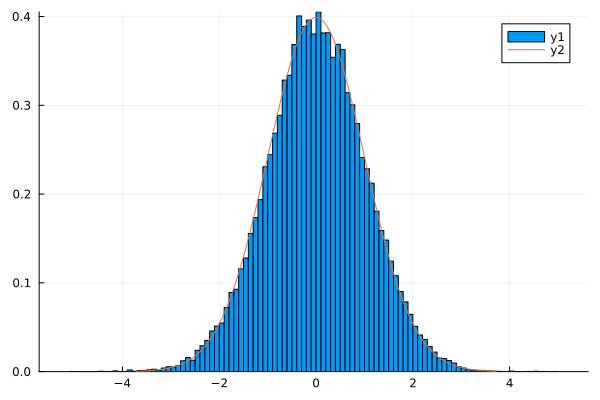

In [86]:
histogram(res, normalize=:pdf)
plot!(Normal())

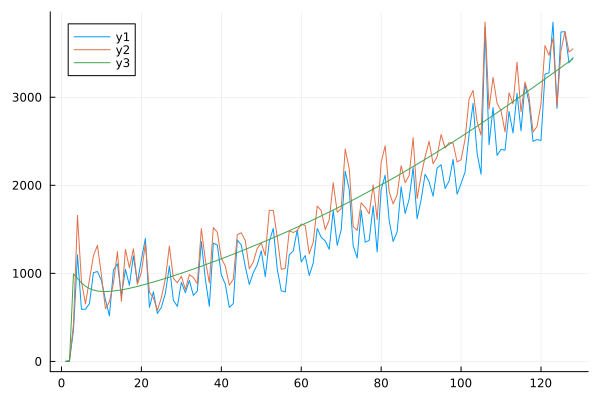

In [17]:
plot(cl2dl(Kl2Cl(result.draws[end-lmax:end,end], comm, root=0), 0))
plot!(cl2dl(Kl2Cl(vec(median(samples_MCHMC[end-3-lmax:end-3,:], dims=2)), comm, root=0), 0))
plot!(cl2dl(realiz_Cl,0))

In [12]:
PF_start_θ = result.draws[:,end]
struct LogTargetDensity
    dim::Int
end

LogDensityProblemsAD.logdensity(p::LogTargetDensity, θ) = -nℓπ(θ)
LogDensityProblemsAD.dimension(p::LogTargetDensity) = p.dim
LogDensityProblemsAD.capabilities(::Type{LogTargetDensity}) = LogDensityProblemsAD.LogDensityOrder{1}()

ℓπ = LogTargetDensity(d)
n_samples, n_adapts = 1_100, 100

metric = DiagEuclideanMetric(d)
ham = Hamiltonian(metric, ℓπ, Zygote)
initial_ϵ = find_good_stepsize(ham, PF_start_θ)
integrator = Leapfrog(initial_ϵ)

kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.9, integrator))

MPI.Barrier(comm)
t0 = time()
samples_NUTS, stats_NUTS = sample(ham, kernel, PF_start_θ, n_samples, adaptor, n_adapts; progress=true, verbose=true, drop_warmup = true)
MPI.Barrier(comm)
NUTS_t = time() - t0

2mSampling   0%|                               |  ETA: 0:21:27











































































































































































































































































































































































































































































































































































































































































































































































































































































































































































5448.190139055252

In [13]:
NUTS_ess, NUTS_rhat = Summarize(samples_NUTS)

([9.865819382738792, 14.883469128600446, 27.969326606567673, 13.935814416437085, 15.509017702122021, 5.68569410182977, 20.889767692101227, 11.330404452674633, 6.154231851157228, 16.707216741723695  …  682.4898778348122, 830.0485829331495, 967.3013167169249, 845.1295672766522, 701.4500311676095, 690.0380247133251, 880.6309230525793, 916.2987626266516, 1047.7321602571728, 900.5230445687256], [1.1546850224196095, 1.123179402082515, 1.022158987233073, 1.0220877609903942, 1.0758686426702442, 1.1795674656651107, 1.020197140184296, 1.057280173060183, 1.181281182281058, 1.0863061330711663  …  1.0012971038142315, 1.0042254008998404, 1.003298268852691, 0.9995291177404745, 1.0022261340719303, 0.9992207601184517, 0.9997171487544416, 0.9998406434617626, 0.9996050054787565, 1.0031327456925299])

In [19]:
mean(NUTS_ess)/NUTS_t

0.034584926253793724

In [21]:
50/120

0.4166666666666667

In [33]:
mean(NUTS_ess)/sum(2 .^ [stats_NUTS[i][:tree_depth] for i in 1:1_000])

0.00018400903728112505

In [ ]:
50/10_000